In [6]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Read the Excel file
df = pd.read_excel('Native_Load_2024.xlsx')

# Replace '24:00' with '00:00' of the next day
df['Hour Ending'] = df['Hour Ending'].apply(lambda x: 
	(pd.to_datetime(x.replace('24:00', '00:00'), errors='coerce') + pd.Timedelta(days=1)).strftime('%m/%d/%Y %H:%M') 
	if '24:00' in x else x)

# Convert to datetime
df.index = pd.to_datetime(df['Hour Ending'], errors='coerce')  # Convert to DatetimeIndex explicitly
df = df.drop('Hour Ending', axis=1)  # Remove the original column
daily_load = df.resample('D')['ERCOT'].mean()

adf_result = adfuller(daily_load)
print(f'ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}')


ADF Statistic: -2.687545247335804, p-value: 0.07621839331013183


In [7]:
diff_load = daily_load.diff().dropna()
adf_result_diff = adfuller(diff_load)
print(f'ADF Statistic (Differenced): {adf_result_diff[0]}, p-value (Differenced): {adf_result_diff[1]}')

ADF Statistic (Differenced): -7.0638745766606785, p-value (Differenced): 5.140128142913234e-10


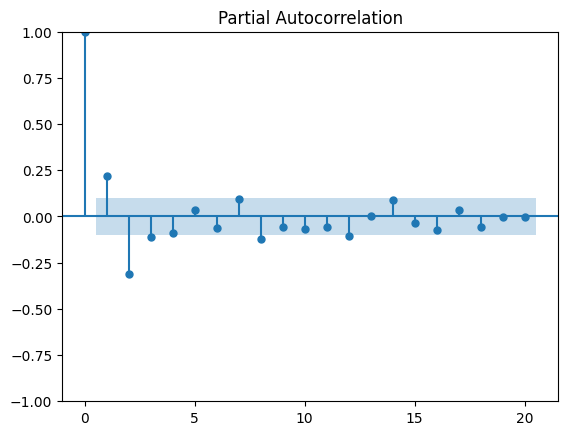

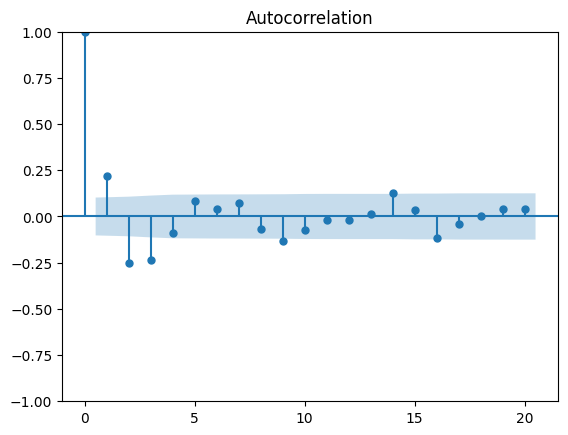

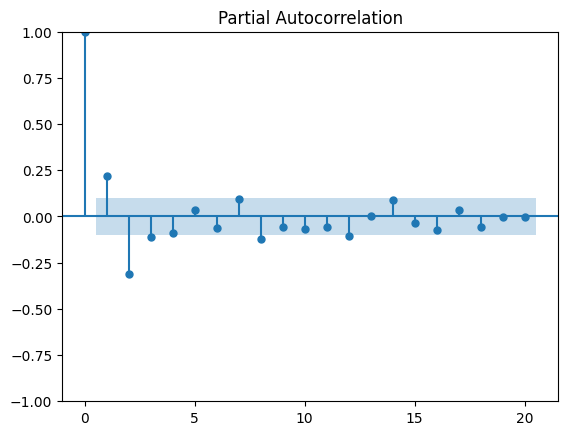

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_load, lags=20)  
plot_pacf(diff_load, lags=20)
  

In [9]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(daily_load, order=(2, 1, 1))  # Adjust the order as needed
results = model.fit()
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:                  ERCOT   No. Observations:                  367
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3353.995
Date:                Sat, 15 Feb 2025   AIC                           6715.989
Time:                        18:31:04   BIC                           6731.600
Sample:                    01-01-2024   HQIC                          6722.193
                         - 01-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5496      0.095      5.802      0.000       0.364       0.735
ar.L2         -0.2755      0.026    -10.797      0.000      -0.326      -0.225
ma.L1         -0.3300      0.108     -3.060      0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


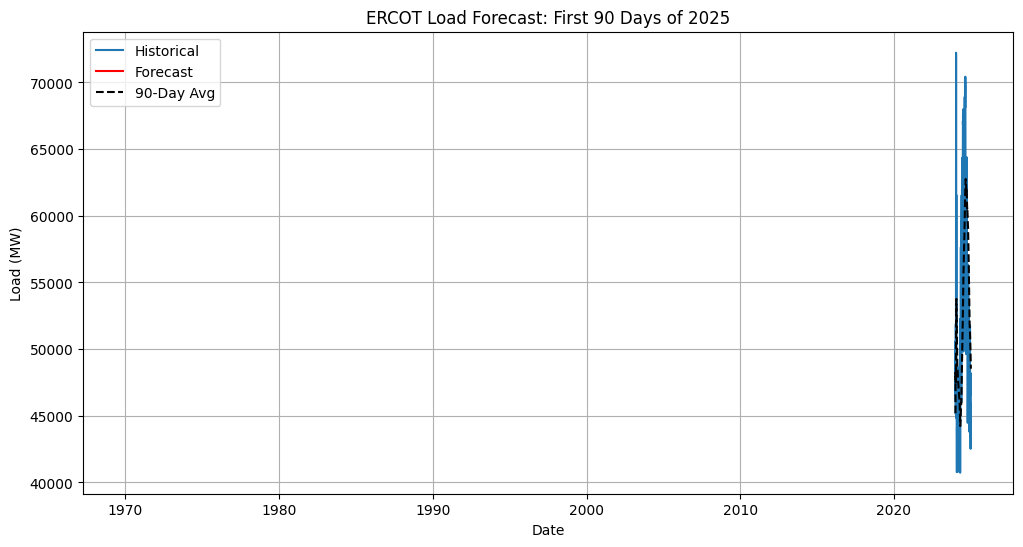

In [15]:
import matplotlib.pyplot as plt

forecast = results.forecast(steps=90)  # Forecast for the next 30 days
mean_forecast = forecast.mean()

rolling_average = daily_load.rolling(window=90, min_periods=1).mean()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(daily_load, label='Historical')
plt.plot(mean_forecast, color='red', label='Forecast')
plt.plot(rolling_average, linestyle='--', color='black', label='90-Day Avg')
plt.title('ERCOT Load Forecast: First 90 Days of 2025')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True)
plt.show()

